# **Proyecto Final Inteligencia Artificial**

### Autores: **Angel David Piñeros Sierra**, **Camilo Andrés Roncancio Toca**, **Kelly Johana Solano Calderón**
### Presentado a: **Darwin Eduardo Martinez Riaño**


---

## **Modelo de segmentación de imágenes para la localización de lesiones asociadas al cáncer de piel**

### *Glosario*

### *(A) Descripción de la problemática*

### *(B) Objetivo*

### *(C) Descripción del dataset*

El dataset seleccionado para la evaluación del modelo fue el denominado “Skin cancer: HAM10000” de la plataforma de Kaggle, el cual ofrece un conjunto de imágenes especiales para realizar tareas de segmentación y clasificación. Para el propósito de segmentación, el dataset incluye para cada una de las imágenes, el conjunto de máscaras qué determinan la segmentación de las lesiones de cáncer de piel. 

> El acrónimo HAM10000 significa “Human Against Machine with 10000 training images”. 

Este dataset es una recopilación de imágenes demoscópicas de diferentes poblaciones. Estas fueron originalmente publicadas inicialmente en el repositorio de Harvard Dataverse,  con el propósito de abordar la dificultad de encontrar un dataset lo suficientemente grande y diverso para realizar diagnósticos automatizados de lesiones cutáneas pigmentadas. 

El dataset se conforma de dos carpetas: images y masks. Cada una con **10015** imágenes en formato **.JPEG**. Todas las imágenes tienen una dimensión de `600px X 450px`

<img src="https://res.cloudinary.com/dlsntlruu/image/upload/v1764556079/carpeta_images_pieoyu.png" width="600px"/>

<img src="https://res.cloudinary.com/dlsntlruu/image/upload/v1764556079/carpeta_masks_taifwn.png" width="600px"/>

Las imágenes incluyen diagnósticos de:
*  Queratosis actínicas
*  Carcinoma intraepitelial
*  Carcinoma basocelular
*  Lesiones de tipo queratosis
*  Dermatofibroma
*  Melanoma
*  Lesiones vasculares

Contar con una amplia gama de diagnósticos permite qué la tarea de segmentación semántica pueda realizarse de forma óptima. 

Para mayor información: 

*  Skin cancer: HAM10000: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification/
*  The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T



### *(D) Importación y organización de datos*


In [36]:
%pip install kaggle pandas torch PILlow torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import subprocess
import random
import shutil
import numpy as np
from pathlib import Path
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms.v2 as v2
from torchvision import tv_tensors
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy
import torch
import torch.nn as nn
import time


In [18]:


dataset_url = "surajghuwalewala/ham1000-segmentation-and-classification"
ruta_descarga = "ham1000_data"

if os.path.exists(ruta_descarga):
    print(f"La carpeta '{ruta_descarga}' ya existe. No se descargará de nuevo.")
else:
    os.makedirs(ruta_descarga, exist_ok=True)
    subprocess.run([
        "kaggle", "datasets", "download",
        "-d", dataset_url,
        "-p", ruta_descarga,
        "--unzip"
    ], check=True)

print("Contenido de la carpeta:", os.listdir(ruta_descarga))

images_dir = os.path.join(ruta_descarga, "images")
masks_dir = os.path.join(ruta_descarga, "masks")

if os.path.isdir(images_dir):
    print("Número de imágenes:", len(os.listdir(images_dir)))
else:
    print("No encontré la carpeta 'images'.")

if os.path.isdir(masks_dir):
    print("Número de máscaras:", len(os.listdir(masks_dir)))
else:
    print("No encontré la carpeta 'masks'.")

La carpeta 'ham1000_data' ya existe. No se descargará de nuevo.
Contenido de la carpeta: ['GroundTruth.csv', 'images', 'masks']
Número de imágenes: 10017
Número de máscaras: 10015


In [19]:
DATA_ROOT = Path('ham1000_data')
OUTPUT_ROOT = Path('ham1000_data_splits')
TRAIN_RATIO = 0.85  # train + val
VAL_FROM_TRAIN = 0.15  # porcentaje de train destinado a validación
SEED = 42
MASK_SUFFIX = '_segmentation.png'

image_dir = DATA_ROOT / 'images'
mask_dir = DATA_ROOT / 'masks'
if not image_dir.exists() or not mask_dir.exists():
    raise RuntimeError(f"No se hallaron carpetas esperadas en {DATA_ROOT}.")

random.seed(SEED)
if OUTPUT_ROOT.exists():
    shutil.rmtree(OUTPUT_ROOT)
for split in ('train', 'val', 'test'):
    (OUTPUT_ROOT / split / 'images').mkdir(parents=True, exist_ok=True)
    (OUTPUT_ROOT / split / 'masks').mkdir(parents=True, exist_ok=True)

allowed_exts = {'.png', '.jpg', '.jpeg'}
image_paths = [p for p in image_dir.iterdir() if p.suffix.lower() in allowed_exts]
if not image_paths:
    raise RuntimeError(f'No se encontraron imágenes en {image_dir}.')
image_paths.sort()
random.shuffle(image_paths)

total = len(image_paths)
train_val_count = int(total * TRAIN_RATIO)
val_count = int(train_val_count * VAL_FROM_TRAIN)
train_count = train_val_count - val_count

splits = {
    'train': image_paths[:train_count],
    'val': image_paths[train_count: train_count + val_count],
    'test': image_paths[train_count + val_count:]
}

for split_name, files in splits.items():
    dst_img = OUTPUT_ROOT / split_name / 'images'
    dst_mask = OUTPUT_ROOT / split_name / 'masks'
    for img_path in files:
        mask_path = mask_dir / f"{img_path.stem}{MASK_SUFFIX}"
        if not mask_path.exists():
            raise FileNotFoundError(f'Falta máscara: {mask_path}')
        shutil.copy2(img_path, dst_img / img_path.name)
        shutil.copy2(mask_path, dst_mask / mask_path.name)
    print(f"{split_name}: {len(files)} imágenes")
print('Splits creados en', OUTPUT_ROOT)



train: 7236 imágenes
val: 1276 imágenes
test: 1503 imágenes
Splits creados en ham1000_data_splits


In [20]:
TRAIN_IMG_DIR = Path('ham1000_data_splits/train/images')
if not TRAIN_IMG_DIR.exists():
    raise RuntimeError(f'No existe el directorio: {TRAIN_IMG_DIR}')

TARGET_SIZE = (256, 256)
resize_transform = transforms.Resize(TARGET_SIZE, interpolation=InterpolationMode.BILINEAR)

img_files = sorted(
    [p for p in TRAIN_IMG_DIR.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}]
)
if not img_files:
    raise RuntimeError(f'No se encontraron imágenes en {TRAIN_IMG_DIR}')

means, stds = [], []
for img_path in img_files:
    img = Image.open(img_path).convert('RGB')
    img_tensor = transforms.ToTensor()(resize_transform(img))
    means.append(img_tensor.mean(dim=(1, 2)))
    stds.append(img_tensor.std(dim=(1, 2)))

IMG_MEAN = torch.stack(means).mean(dim=0)
IMG_STD = torch.stack(stds).mean(dim=0)
print(f'Media por canal (reescala {TARGET_SIZE[0]}x{TARGET_SIZE[1]}): {IMG_MEAN.tolist()}')
print(f'Desviación estándar por canal: {IMG_STD.tolist()}')



Media por canal (reescala 256x256): [0.7633206844329834, 0.5454925894737244, 0.5698098540306091]
Desviación estándar por canal: [0.08873128145933151, 0.11731848120689392, 0.13180507719516754]


In [21]:
normalize_transform = v2.Normalize(mean=IMG_MEAN, std=IMG_STD)

train_joint_transform = v2.Compose([
    v2.Resize(TARGET_SIZE, interpolation=InterpolationMode.BILINEAR, antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.2),
    v2.RandomRotation(degrees=(-180, 180)),
    v2.ElasticTransform(alpha=40.0, sigma=5.0, interpolation=InterpolationMode.BILINEAR),
    v2.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.2, hue=0.02),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.ToDtype(torch.float32, scale=True),
    normalize_transform,
])

val_test_joint_transform = v2.Compose([
    v2.Resize(TARGET_SIZE, interpolation=InterpolationMode.BILINEAR, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    normalize_transform,
])

def apply_train_transforms(image, mask):
    image_tv = tv_tensors.Image(image)
    mask_tv = tv_tensors.Mask(mask)
    image_aug, mask_aug = train_joint_transform(image_tv, mask_tv)
    return image_aug, mask_aug

def apply_val_transforms(image, mask):
    image_tv = tv_tensors.Image(image)
    mask_tv = tv_tensors.Mask(mask)
    image_val, mask_val = val_test_joint_transform(image_tv, mask_tv)
    return image_val, mask_val

def apply_test_transforms(image, mask):
    image_tv = tv_tensors.Image(image)
    mask_tv = tv_tensors.Mask(mask)
    image_test, mask_test = val_test_joint_transform(image_tv, mask_tv)
    return image_test, mask_test

print("Transformaciones definidas:")
print("train_joint_transform:", train_joint_transform)
print("val_test_joint_transform:", val_test_joint_transform)



Transformaciones definidas:
train_joint_transform: Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.2)
      RandomRotation(degrees=[-180.0, 180.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      ElasticTransform(alpha=[40.0, 40.0], sigma=[5.0, 5.0], interpolation=InterpolationMode.BILINEAR, fill=0)
      ColorJitter(brightness=(0.85, 1.15), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.02, 0.02))
      GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 1.0])
      ToDtype(scale=True)
      Normalize(mean=[tensor(0.7633), tensor(0.5455), tensor(0.5698)], std=[tensor(0.0887), tensor(0.1173), tensor(0.1318)], inplace=False)
)
val_test_joint_transform: Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[tensor(0.7633), tensor(0.5455), tensor(0.5698)], std=[tensor(0.0

Mostrando augmentations para: ISIC_0024306.jpg


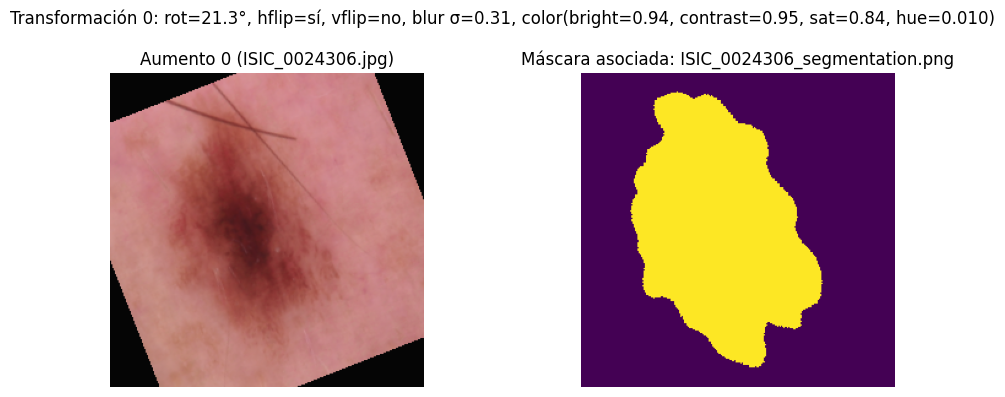

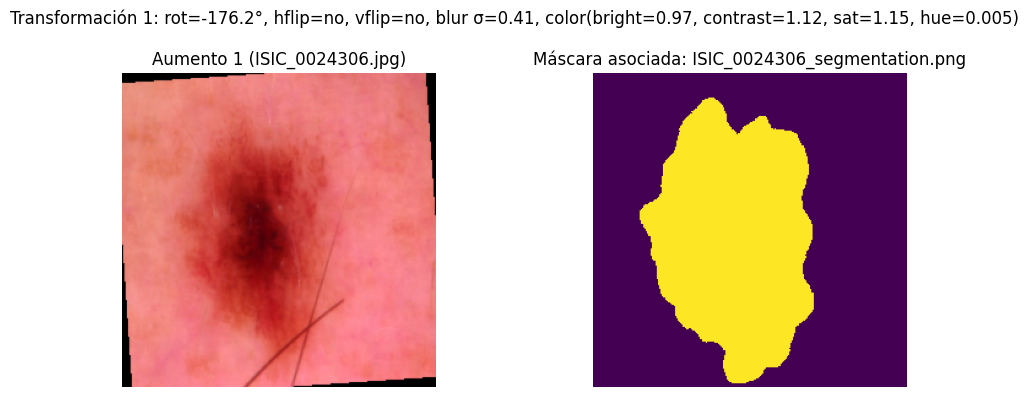

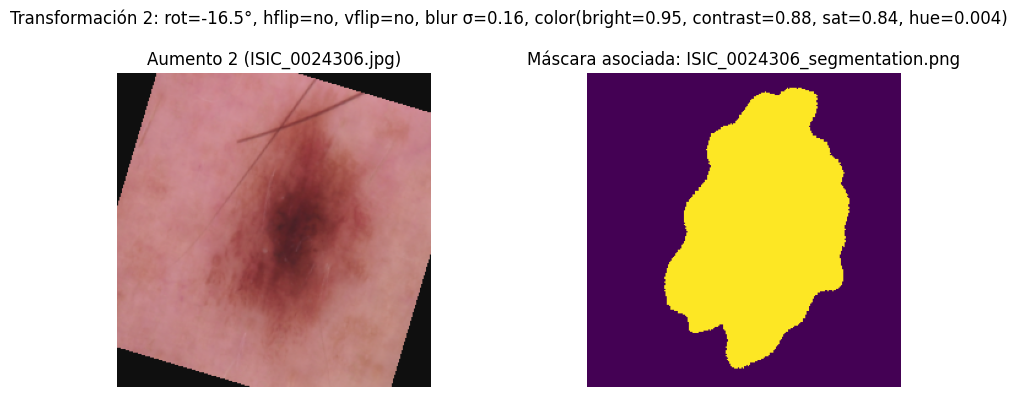

In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageOps
from torchvision.transforms import functional as TF

def preview_training_aug(image, mask):
    metadata = {}
    img = image.copy()
    msk = mask.copy()
    img = img.resize(TARGET_SIZE, resample=Image.BILINEAR)
    msk = msk.resize(TARGET_SIZE, resample=Image.NEAREST)
    if random.random() < 0.5:
        img = ImageOps.mirror(img)
        msk = ImageOps.mirror(msk)
        metadata['hflip'] = True
    else:
        metadata['hflip'] = False
    if random.random() < 0.2:
        img = ImageOps.flip(img)
        msk = ImageOps.flip(msk)
        metadata['vflip'] = True
    else:
        metadata['vflip'] = False
    rotation_deg = random.uniform(-180, 180)
    metadata['rotation_deg'] = rotation_deg
    img = img.rotate(rotation_deg, resample=Image.BILINEAR, fillcolor=(0, 0, 0))
    msk = msk.rotate(rotation_deg, resample=Image.NEAREST, fillcolor=0)
    img_tensor = TF.to_tensor(img)
    mask_tensor = torch.from_numpy((np.array(msk) > 0).astype(np.int64))
    brightness = random.uniform(0.85, 1.15)
    contrast = random.uniform(0.8, 1.2)
    saturation = random.uniform(0.8, 1.2)
    hue = random.uniform(-0.02, 0.02)
    metadata.update({
        'brightness': brightness,
        'contrast': contrast,
        'saturation': saturation,
        'hue': hue,
    })
    img_tensor = TF.adjust_brightness(img_tensor, brightness)
    img_tensor = TF.adjust_contrast(img_tensor, contrast)
    img_tensor = TF.adjust_saturation(img_tensor, saturation)
    img_tensor = TF.adjust_hue(img_tensor, hue)
    sigma = random.uniform(0.1, 1.0)
    metadata['blur_sigma'] = sigma
    img_tensor = TF.gaussian_blur(img_tensor, kernel_size=3, sigma=sigma)
    aug_img = normalize_transform(img_tensor)
    return aug_img, mask_tensor, metadata

VISUAL_SAMPLES = 3
train_img_dir = Path('ham1000_data_splits/train/images')
train_mask_dir = Path('ham1000_data_splits/train/masks')
sample_paths = sorted([p for p in train_img_dir.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])
if not sample_paths:
    raise RuntimeError('No se hallaron imágenes en ham1000_data_splits/train/images')
sample_img_path = sample_paths[0]
sample_mask_path = train_mask_dir / f"{sample_img_path.stem}{MASK_SUFFIX}"
if not sample_mask_path.exists():
    raise FileNotFoundError(f'No existe la máscara asociada: {sample_mask_path}')
print(f'Mostrando augmentations para: {sample_img_path.name}')
orig_img = Image.open(sample_img_path).convert('RGB')
orig_mask = Image.open(sample_mask_path).convert('L')
mean = IMG_MEAN.view(3, 1, 1)
std = IMG_STD.view(3, 1, 1)
for idx in range(VISUAL_SAMPLES):
    aug_img, aug_mask, metadata = preview_training_aug(orig_img, orig_mask)
    aug_img_denorm = (aug_img * std + mean).clamp(0, 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(aug_img_denorm.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title(f'Aumento {idx} ({sample_img_path.name})')
    axes[0].axis('off')
    axes[1].imshow(aug_mask.cpu().numpy(), vmin=0, vmax=NUM_CLASSES - 1, cmap='viridis')
    axes[1].set_title(f'Máscara asociada: {sample_mask_path.name}')
    axes[1].axis('off')
    geom = (
        f"rot={metadata['rotation_deg']:.1f}°, "
        f"hflip={'sí' if metadata['hflip'] else 'no'}, "
        f"vflip={'sí' if metadata['vflip'] else 'no'}, "
        f"blur σ={metadata['blur_sigma']:.2f}"
    )
    color_txt = (
        f"color(bright={metadata['brightness']:.2f}, contrast={metadata['contrast']:.2f}, "
        f"sat={metadata['saturation']:.2f}, hue={metadata['hue']:.3f})"
    )
    fig.suptitle(f"Transformación {idx}: {geom}, {color_txt}")
    plt.tight_layout()
    plt.show()


In [24]:
class HAM1000SegmentationDataset(Dataset):
    def __init__(self, root_dir: Path, split: str, transform_fn=None, mask_suffix: str = '_segmentation.png'):
        self.root_dir = Path(root_dir)
        if split not in {'train', 'val', 'test'}:
            raise ValueError("split debe ser 'train', 'val' o 'test'")
        self.split = split
        self.images_dir = self.root_dir / split / 'images'
        self.masks_dir = self.root_dir / split / 'masks'
        if not self.images_dir.exists() or not self.masks_dir.exists():
            raise RuntimeError(f'No se hallan carpetas para el split {split} en {self.root_dir}')
        self.mask_suffix = mask_suffix
        self.transform_fn = transform_fn

        allowed_exts = {'.png', '.jpg', '.jpeg'}
        self.samples = []
        for img_path in sorted(self.images_dir.iterdir()):
            if img_path.suffix.lower() not in allowed_exts:
                continue
            mask_path = self.masks_dir / f"{img_path.stem}{self.mask_suffix}"
            if not mask_path.exists():
                continue
            self.samples.append((img_path, mask_path))
        if not self.samples:
            raise RuntimeError(f'No se encontraron pares imagen-máscara en {self.images_dir}')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        if self.transform_fn is not None:
            image, mask = self.transform_fn(image, mask)
        return image, mask


def get_transform_fn(split: str):
    if split == 'train':
        return apply_train_transforms
    if split == 'val':
        return apply_val_transforms
    if split == 'test':
        return apply_test_transforms
    raise ValueError('split desconocido')


def create_datasets(root_dir: Path = Path('ham1000_data_splits')):
    datasets = {}
    for split in ('train', 'val', 'test'):
        datasets[split] = HAM1000SegmentationDataset(
            root_dir=root_dir,
            split=split,
            transform_fn=get_transform_fn(split),
        )
        print(f"{split}: {len(datasets[split])} muestras")
    return datasets

ham_datasets = create_datasets()



train: 7236 muestras
val: 1276 muestras
test: 1503 muestras


In [8]:
BATCH_SIZE = 8
NUM_WORKERS = 4
PIN_MEMORY = True

train_loader = DataLoader(
    ham_datasets['train'],
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    ham_datasets['val'],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    ham_datasets['test'],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print('Loaders listos:')
print(f"train: {len(train_loader)} batches")
print(f"val: {len(val_loader)} batches")
print(f"test: {len(test_loader)} batches")



Loaders listos:
train: 905 batches
val: 160 batches
test: 188 batches


In [9]:
class ResidualBlock(nn.Module):
    """Two Conv-BN blocks with a residual shortcut."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + identity
        return F.relu(out)

class Down(nn.Module):
    """MaxPool + ResidualBlock encoder stage."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.resblock = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.resblock(x)
        return x

class Up(nn.Module):
    """ConvTranspose2d upsampling + concat + ResidualBlock."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.resblock = ResidualBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_y = x2.size(2) - x1.size(2)
        diff_x = x2.size(3) - x1.size(3)
        if diff_y != 0 or diff_x != 0:
            x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.resblock(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class ResUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super().__init__()
        self.inc = ResidualBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
def _ensure_multiclass_logits(preds):
    if preds.ndim != 4:
        raise ValueError('preds debe tener forma [B, C, H, W]')
    if preds.shape[1] == 1:
        probs = torch.sigmoid(preds)
        return torch.cat([1.0 - probs, probs], dim=1)
    return preds

def pixel_accuracy(preds, targets):
    preds = _ensure_multiclass_logits(preds)
    pred_labels = torch.argmax(preds, dim=1)
    correct = (pred_labels == targets).float().sum()
    total = torch.numel(targets)
    return (correct / total).item()

def _per_class_iou(pred_labels, targets, num_classes=2, eps=1e-6):
    per_class = {}
    for cls in range(num_classes):
        pred_cls = pred_labels == cls
        target_cls = targets == cls
        intersection = (pred_cls & target_cls).float().sum()
        union = (pred_cls | target_cls).float().sum()
        if union == 0:
            continue
        per_class[cls] = ((intersection + eps) / (union + eps)).item()
    return per_class

def _per_class_dice(pred_labels, targets, num_classes=2, eps=1e-6):
    per_class = {}
    for cls in range(num_classes):
        pred_cls = pred_labels == cls
        target_cls = targets == cls
        intersection = (pred_cls & target_cls).float().sum()
        pred_sum = pred_cls.float().sum()
        target_sum = target_cls.float().sum()
        denom = pred_sum + target_sum
        if denom == 0:
            continue
        per_class[cls] = ((2 * intersection + eps) / (denom + eps)).item()
    return per_class

def compute_jaccard(preds, targets, num_classes=2, eps=1e-6):
    preds = _ensure_multiclass_logits(preds)
    pred_labels = torch.argmax(preds, dim=1)
    per_class = _per_class_iou(pred_labels, targets, num_classes, eps)
    if not per_class:
        return {'mean': 0.0, 'per_class': per_class}
    mean_score = sum(per_class.values()) / len(per_class)
    return {'mean': mean_score, 'per_class': per_class}

def compute_dice(preds, targets, num_classes=2, eps=1e-6):
    preds = _ensure_multiclass_logits(preds)
    pred_labels = torch.argmax(preds, dim=1)
    per_class = _per_class_dice(pred_labels, targets, num_classes, eps)
    if not per_class:
        return {'mean': 0.0, 'per_class': per_class}
    mean_score = sum(per_class.values()) / len(per_class)
    return {'mean': mean_score, 'per_class': per_class}


In [ ]:
WEIGHTS_PATH = Path('resunet_gsd_lr5e4.pt')
device = get_device()
model = ResUNet().to(device)

checkpoint = torch.load(WEIGHTS_PATH, map_location=device)
state_dict = (
    checkpoint.get('state_dict')
    or checkpoint.get('model_state_dict')
    or checkpoint
)
for key in ('outc.conv.weight', 'outc.conv.bias'):
    state_dict.pop(key, None)
missing = model.load_state_dict(state_dict, strict=False)
model.eval()
print(f'Modelo cargado desde {WEIGHTS_PATH}')
print('Dispositivo:', device)
print('Keys ignoradas:', missing.missing_keys)


Modelo cargado desde resunet_gsd_lr5e4.pt
Dispositivo: cpu
Keys ignoradas: ['outc.conv.weight', 'outc.conv.bias']


In [12]:

random.seed(48)

OPTIMIZERS = ('adam', 'adamw', 'sgd')
WEIGHT_DECAY_VALUES = (0.0, 1e-4, 5e-4)
MOMENTUM_VALUES = (0.85, 0.9, 0.95, 0.99)
SCHEDULERS = {
    'none': {},
    'steplr': {'step_size': (15, 30), 'gamma': (0.5, 0.1)},
    'cosine': {'t_max': (20, 40)},
    'plateau': {'patience': (3, 5), 'factor': (0.3, 0.1)},
}

def sample_lr(opt_name):
    if opt_name == 'sgd':
        return 10 ** random.uniform(-2.3, -1.5)
    if opt_name == 'adamw':
        return 10 ** random.uniform(-4.3, -3.0)
    return 10 ** random.uniform(-4.0, -3.0)

def sample_scheduler_params(name):
    params = {}
    cfg = SCHEDULERS[name]
    for key, bounds in cfg.items():
        params[key] = random.choice(bounds)
    return params

def sample_trial():
    opt_name = random.choice(OPTIMIZERS)
    weight_decay = random.choice(WEIGHT_DECAY_VALUES)
    lr = sample_lr(opt_name)
    scheduler = random.choice(tuple(SCHEDULERS.keys()))
    trial = {
        'optimizer': opt_name,
        'learning_rate': round(lr, 6),
        'weight_decay': weight_decay,
        'scheduler': scheduler,
        'scheduler_params': sample_scheduler_params(scheduler),
    }
    if opt_name == 'sgd':
        trial['momentum'] = random.choice(MOMENTUM_VALUES)
    return trial

NUM_TRIALS = 10
random_trials = [sample_trial() for _ in range(NUM_TRIALS)]

for idx, cfg in enumerate(random_trials, start=1):
    print(f'Trial {idx}:')
    for key, value in cfg.items():
        print(f'  {key}: {value}')
    print('-' * 30)



Trial 1:
  optimizer: sgd
  learning_rate: 0.00639
  weight_decay: 0.0001
  scheduler: cosine
  scheduler_params: {'t_max': 20}
  momentum: 0.99
------------------------------
Trial 2:
  optimizer: adam
  learning_rate: 0.000925
  weight_decay: 0.0
  scheduler: none
  scheduler_params: {}
------------------------------
Trial 3:
  optimizer: adamw
  learning_rate: 9.7e-05
  weight_decay: 0.0005
  scheduler: steplr
  scheduler_params: {'step_size': 30, 'gamma': 0.5}
------------------------------
Trial 4:
  optimizer: adam
  learning_rate: 0.000265
  weight_decay: 0.0
  scheduler: steplr
  scheduler_params: {'step_size': 30, 'gamma': 0.5}
------------------------------
Trial 5:
  optimizer: adam
  learning_rate: 0.000499
  weight_decay: 0.0
  scheduler: cosine
  scheduler_params: {'t_max': 40}
------------------------------
Trial 6:
  optimizer: sgd
  learning_rate: 0.005969
  weight_decay: 0.0001
  scheduler: steplr
  scheduler_params: {'step_size': 30, 'gamma': 0.1}
  momentum: 0.85
--

### Métricas y helpers

Se define las utilidades de métricas que usa todo el loop de entrenamiento para medir cómo va el modelo en segmentación binaria:

- MetricAccumulator se encarga de acumular durante toda la epoca los conteos necesarios para calcular las métricas por cada clase
- prepare_targets prepara las mascaras 
- summarize_metrics nos muestra las métricas en un formato legible

Notese que apesar de haber previamente definido la salida de la red a un numero de clases = 2, acá lo definimos nuevamente en una variable global para estos propositos definidos.

**Convención de clases:** 0 = fondo, 1 = lesión.


In [ ]:
NUM_CLASSES = 2
EPS = 1e-6
class MetricAccumulator:
    def __init__(self, num_classes=NUM_CLASSES, eps=EPS):
        self.num_classes = num_classes
        self.eps = eps
        self.reset()

    def reset(self):
        self.intersection = torch.zeros(self.num_classes, dtype=torch.float64)
        self.union = torch.zeros(self.num_classes, dtype=torch.float64)
        self.pred_sum = torch.zeros(self.num_classes, dtype=torch.float64)
        self.target_sum = torch.zeros(self.num_classes, dtype=torch.float64)
        self.correct = 0.0
        self.total = 0.0

    def update(self, logits, targets):
        preds = _ensure_multiclass_logits(logits.detach())
        pred_labels = torch.argmax(preds, dim=1)
        targets = targets.long()
        self.correct += (pred_labels == targets).sum().item()
        self.total += targets.numel()
        for cls in range(self.num_classes):
            pred_mask = pred_labels == cls
            target_mask = targets == cls
            intersection = (pred_mask & target_mask).sum().item()
            union = (pred_mask | target_mask).sum().item()
            self.intersection[cls] += intersection
            self.union[cls] += union
            self.pred_sum[cls] += pred_mask.sum().item()
            self.target_sum[cls] += target_mask.sum().item()

    def export(self):
        per_class_iou = {}
        per_class_dice = {}
        for cls in range(self.num_classes):
            if self.union[cls] > 0:
                per_class_iou[cls] = (self.intersection[cls] + self.eps) / (self.union[cls] + self.eps)
            if (self.pred_sum[cls] + self.target_sum[cls]) > 0:
                per_class_dice[cls] = (2 * self.intersection[cls] + self.eps) / (self.pred_sum[cls] + self.target_sum[cls] + self.eps)
        mean_iou = sum(per_class_iou.values()) / len(per_class_iou) if per_class_iou else 0.0
        mean_dice = sum(per_class_dice.values()) / len(per_class_dice) if per_class_dice else 0.0
        acc = self.correct / self.total if self.total else 0.0
        return {
            'pixel_acc': acc,
            'jaccard': {'mean': mean_iou, 'per_class': per_class_iou},
            'dice': {'mean': mean_dice, 'per_class': per_class_dice},
        }

def prepare_targets(mask_tensor):
    if mask_tensor.ndim == 4 and mask_tensor.size(1) == 1:
        mask_tensor = mask_tensor.squeeze(1)
    mask_tensor = (mask_tensor > 0).long()
    return mask_tensor

def summarize_metrics(split_name, metrics):
    dice = metrics['dice']
    jacc = metrics['jaccard']
    parts = [
        f"{split_name} loss={metrics['loss']:.4f}",
        f"pixAcc={metrics['pixel_acc']:.4f}",
        f"dice={dice['mean']:.4f}",
        f"jacc={jacc['mean']:.4f}",
    ]
    for cls, score in sorted(dice['per_class'].items()):
        parts.append(f"dice_c{cls}={score:.4f}")
    for cls, score in sorted(jacc['per_class'].items()):
        parts.append(f"jacc_c{cls}={score:.4f}")
    return ' | '.join(parts)

### Configuración optimizadores
Se agrupan helpers que preparan cada trial o experimento antes de entrenar y carga el checkpoint del modelo previamente entrenado:
- build_optimizer recibe el modelo de ResUNet y el diccionario donde están todas las configuraciones para ese trial y devuelve la función de perdida elegida allí
- build_scheduler recibe el modelo de ResUNet y el diccionario donde están todas las configuraciones para ese trial y devuelve el scheduler seleccionado allí
- prepare_base_state carga el checkpoint o modelo que ya se había entrenado previamente

In [ ]:
def build_optimizer(model, cfg):
    params = [p for p in model.parameters() if p.requires_grad]
    if cfg['optimizer'] == 'adam':
        return torch.optim.Adam(params, lr=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
    if cfg['optimizer'] == 'adamw':
        return torch.optim.AdamW(params, lr=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
    return torch.optim.SGD(
        params,
        lr=cfg['learning_rate'],
        momentum=cfg.get('momentum', 0.9),
        weight_decay=cfg['weight_decay'],
    )

def build_scheduler(optimizer, cfg, total_epochs):
    name = cfg.get('scheduler', 'none')
    params = cfg.get('scheduler_params', {}) or {}
    if name == 'steplr':
        return torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=params.get('step_size', 30),
            gamma=params.get('gamma', 0.1),
        )
    if name == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=params.get('t_max', total_epochs),
        )
    if name == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            patience=params.get('patience', 4),
            factor=params.get('factor', 0.3),
        )
    return None

def prepare_base_state(weights_path, device):
    if weights_path is None:
        return None
    weights_path = Path(weights_path)
    if not weights_path.exists():
        print(f"Advertencia: no se encontró {weights_path}")
        return None
    checkpoint = torch.load(weights_path, map_location=device)
    state_dict = (
        checkpoint.get('state_dict')
        or checkpoint.get('model_state_dict')
        or checkpoint
    )
    state_dict = dict(state_dict)
    state_dict.pop('outc.conv.weight', None)
    state_dict.pop('outc.conv.bias', None)
    return state_dict


#### Entrenamiento/validación por época
Ejecuta un epoch completo (train o val), aplicando la función de perdida, actualizando el optimizador si corresponde y acumulando métricas por clase mediante MetricAccumulator. Devuelve un diccionario con loss, pixel_acc, Dice y Jaccard (promedio y por clase) para el split que se haya procesado.

In [ ]:
def train_or_eval_epoch(
    model,
    loader,
    optimizer,
    criterion,
    device,
    train_mode=True,
    loss_type='cross_entropy',
    num_classes=NUM_CLASSES,
):
    model.train(mode=train_mode)
    accumulator = MetricAccumulator(num_classes=num_classes)
    running_loss = 0.0
    data_count = len(loader.dataset)
    with torch.set_grad_enabled(train_mode):
        for images, masks in loader:
            images = images.to(device)
            targets = prepare_targets(masks.to(device))
            logits = model(images)
            if loss_type == 'bce':
                if logits.ndim == 3:
                    logits = logits.unsqueeze(1)
                target_float = targets.unsqueeze(1).float()
                loss = criterion(logits, target_float)
            else:
                loss = criterion(logits, targets.long())
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * images.size(0)
            accumulator.update(logits, targets)
    metrics = accumulator.export()
    metrics['loss'] = running_loss / max(1, data_count)
    return metrics


Luego, se orquesta la ejecución completa de un experimento (un trial, una configuración de hiperparametros dada)

In [ ]:
def run_single_trial(
    cfg,
    num_epochs=10,
    loss_type='cross_entropy',
    base_state_dict=None,
    weights_path=None,
):
    device = get_device()
    output_channels = NUM_CLASSES if loss_type != 'bce' else 1
    model = ResUNet(n_channels=3, n_classes=output_channels).to(device)
    loaded_state = None
    if base_state_dict is not None:
        loaded_state = base_state_dict
    elif weights_path is not None:
        loaded_state = prepare_base_state(weights_path, device)
    if loaded_state is not None:
        model.load_state_dict(loaded_state, strict=False)
    criterion = nn.BCEWithLogitsLoss() if loss_type == 'bce' else nn.CrossEntropyLoss()
    optimizer = build_optimizer(model, cfg)
    scheduler = build_scheduler(optimizer, cfg, total_epochs=num_epochs)
    history = []
    best_val = -float('inf')
    best_state = None
    for epoch in range(1, num_epochs + 1):
        start = time.time()
        train_metrics = train_or_eval_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            device,
            train_mode=True,
            loss_type=loss_type,
            num_classes=NUM_CLASSES,
        )
        val_metrics = train_or_eval_epoch(
            model,
            val_loader,
            optimizer,
            criterion,
            device,
            train_mode=False,
            loss_type=loss_type,
            num_classes=NUM_CLASSES,
        )
        monitor = val_metrics['dice']['mean']
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(monitor)
            else:
                scheduler.step()
        if monitor > best_val:
            best_val = monitor
            best_state = deepcopy(model.state_dict())
        epoch_time = time.time() - start
        history.append(
            {
                'epoch': epoch,
                'train': train_metrics,
                'val': val_metrics,
                'lr': optimizer.param_groups[0]['lr'],
                'time': epoch_time,
            }
        )
        train_summary = summarize_metrics('train', train_metrics)
        val_summary = summarize_metrics('val', val_metrics)
        print(
            f"[Trial {cfg['optimizer']} | Epoch {epoch}] {train_summary} || {val_summary} || "
            f"lr={optimizer.param_groups[0]['lr']:.2e}"
        )
    return {
        'config': cfg,
        'history': history,
        'best_val_dice': best_val,
        'best_state_dict': best_state,
    }


### Rutina de entrenamiento
Esta función es la encargada de correr cada configuración de hiperparametros, entrena el modelo y mantiene un ranking con los 3 mejores resultados

In [ ]:
def run_trials(
    trials,
    num_epochs=10,
    loss_type='cross_entropy',
    weights_path=None,
    top_k=3,
    output_dir=Path('experiments'),
):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    device = get_device()
    base_state_dict = prepare_base_state(weights_path, device) if weights_path else None
    results = []
    top_models = []
    for idx, cfg in enumerate(trials, start=1):
        print(f'===== Trial {idx}/{len(trials)} =====')
        result = run_single_trial(
            cfg,
            num_epochs=num_epochs,
            loss_type=loss_type,
            base_state_dict=base_state_dict,
        )
        results.append(result)
        dice_score = result['best_val_dice']
        save_path = output_dir / f"trial_{idx:03d}_dice_{dice_score:.4f}.pt"
        torch.save(
            {
                'config': result['config'],
                'state_dict': result['best_state_dict'],
                'history': result['history'],
                'best_val_dice': dice_score,
            },
            save_path,
        )
        top_models.append({'score': dice_score, 'path': save_path, 'config': result['config']})
        top_models.sort(key=lambda item: item['score'], reverse=True)
        while len(top_models) > top_k:
            removed = top_models.pop()
            if removed['path'].exists():
                removed['path'].unlink()
        print('Top actual:')
        for rank, item in enumerate(top_models, start=1):
            print(f"  {rank}) Dice={item['score']:.4f} -> {item['path'].name}")
    return {'results': results, 'top_models': top_models}

#### Entrenamiento y visualización de los mejores trials
entrena los trials y, con el resumen obtenido, genera automáticamente las gráficas de loss/pixel accuracy/Dice/Jaccard para los tres mejores modelos según Dice de validación.

¿por qué Dice y no la función de perdida normal?

Usamos el Dice de validación como criterio porque mide directamente la superposición entre la máscara predicha y la real, que es el objetivo principal en segmentación. En lugar de por ejemplo el pixel accuracy que solo distingue si coincide o no el pixel predicho con el de la máscara.

===== Trial 1/10 =====
[Trial sgd | Epoch 1] train loss=0.2723 | pixAcc=0.8935 | dice=0.8544 | jacc=0.7534 | dice_c0=0.9298 | dice_c1=0.7790 | jacc_c0=0.8688 | jacc_c1=0.6380 || val loss=0.2331 | pixAcc=0.8947 | dice=0.8606 | jacc=0.7617 | dice_c0=0.9296 | dice_c1=0.7916 | jacc_c0=0.8684 | jacc_c1=0.6551 || lr=2.08e-02
[Trial sgd | Epoch 2] train loss=0.2135 | pixAcc=0.9192 | dice=0.8931 | jacc=0.8109 | dice_c0=0.9460 | dice_c1=0.8401 | jacc_c0=0.8975 | jacc_c1=0.7244 || val loss=0.1900 | pixAcc=0.9276 | dice=0.9107 | jacc=0.8384 | dice_c0=0.9496 | dice_c1=0.8718 | jacc_c0=0.9040 | jacc_c1=0.7727 || lr=2.05e-02
[Trial sgd | Epoch 3] train loss=0.1755 | pixAcc=0.9312 | dice=0.9093 | jacc=0.8368 | dice_c0=0.9539 | dice_c1=0.8647 | jacc_c0=0.9119 | jacc_c1=0.7616 || val loss=0.1532 | pixAcc=0.9396 | dice=0.9242 | jacc=0.8609 | dice_c0=0.9584 | dice_c1=0.8899 | jacc_c0=0.9201 | jacc_c1=0.8017 || lr=1.98e-02
[Trial sgd | Epoch 4] train loss=0.1580 | pixAcc=0.9387 | dice=0.9196 | jacc=0.8535

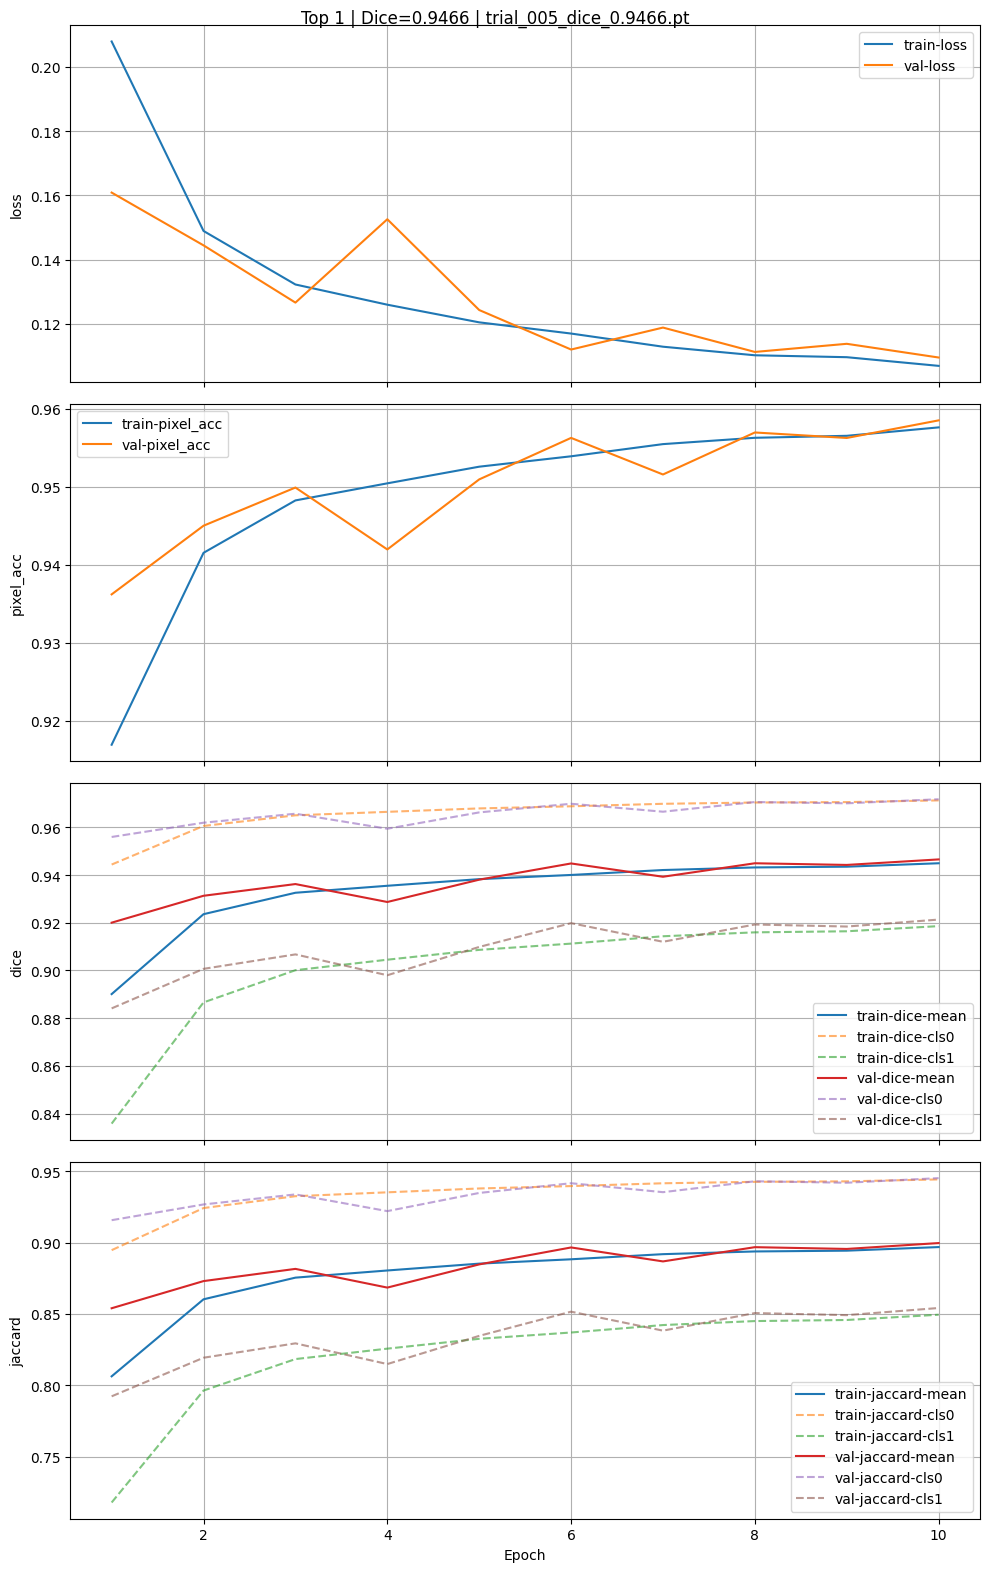

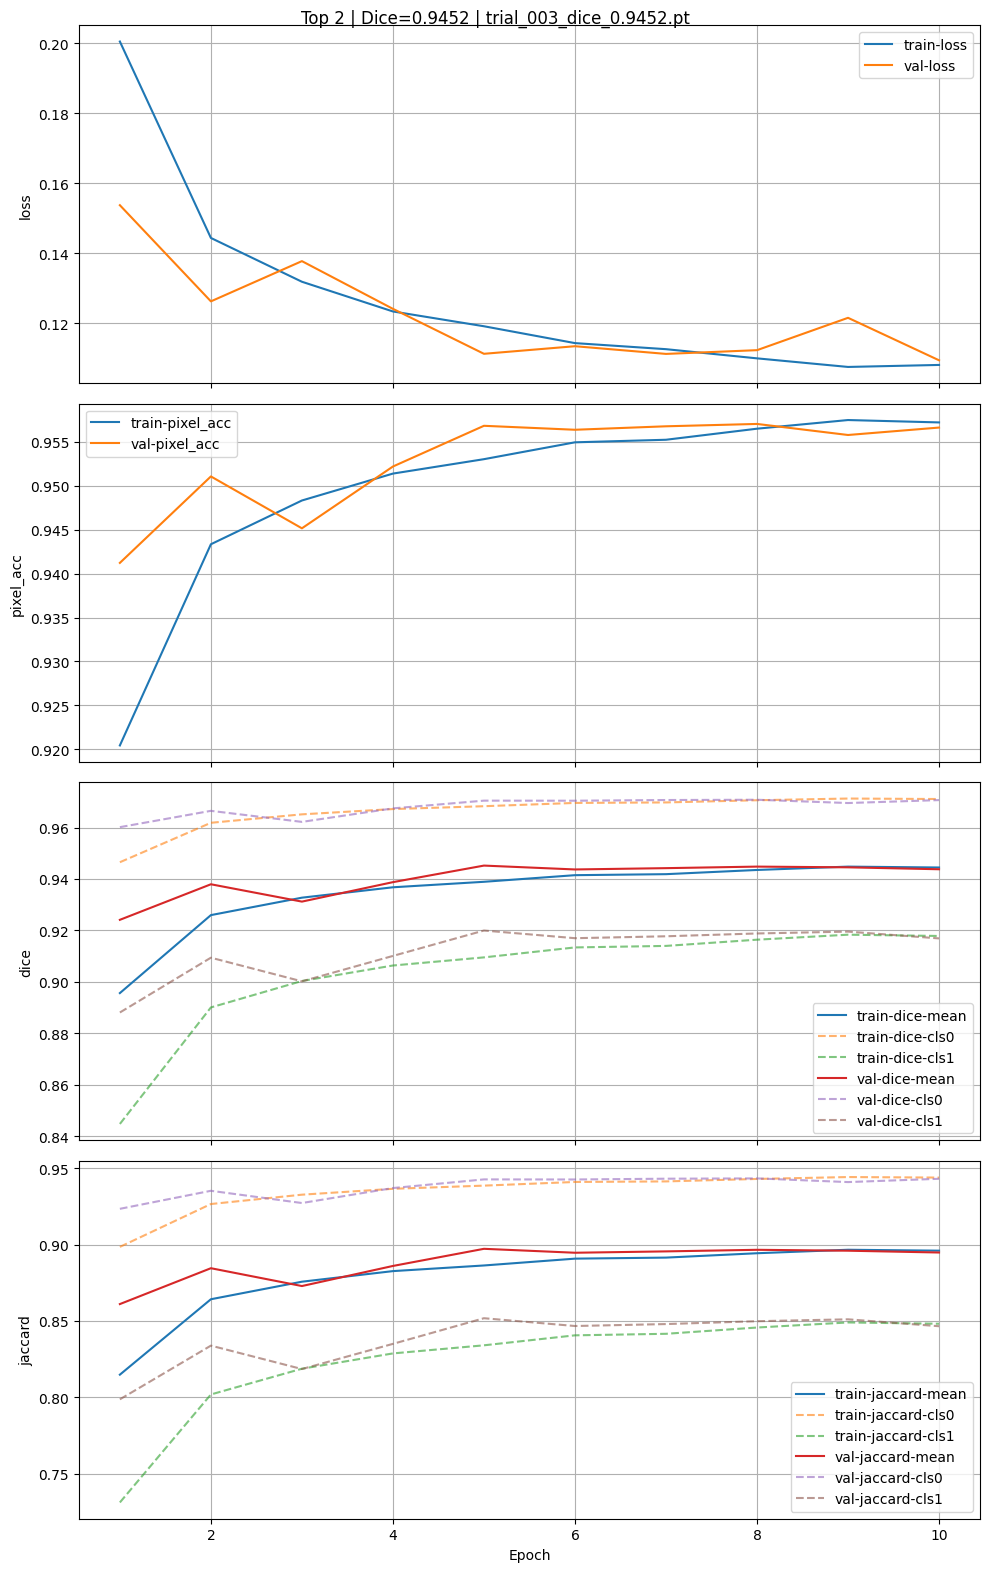

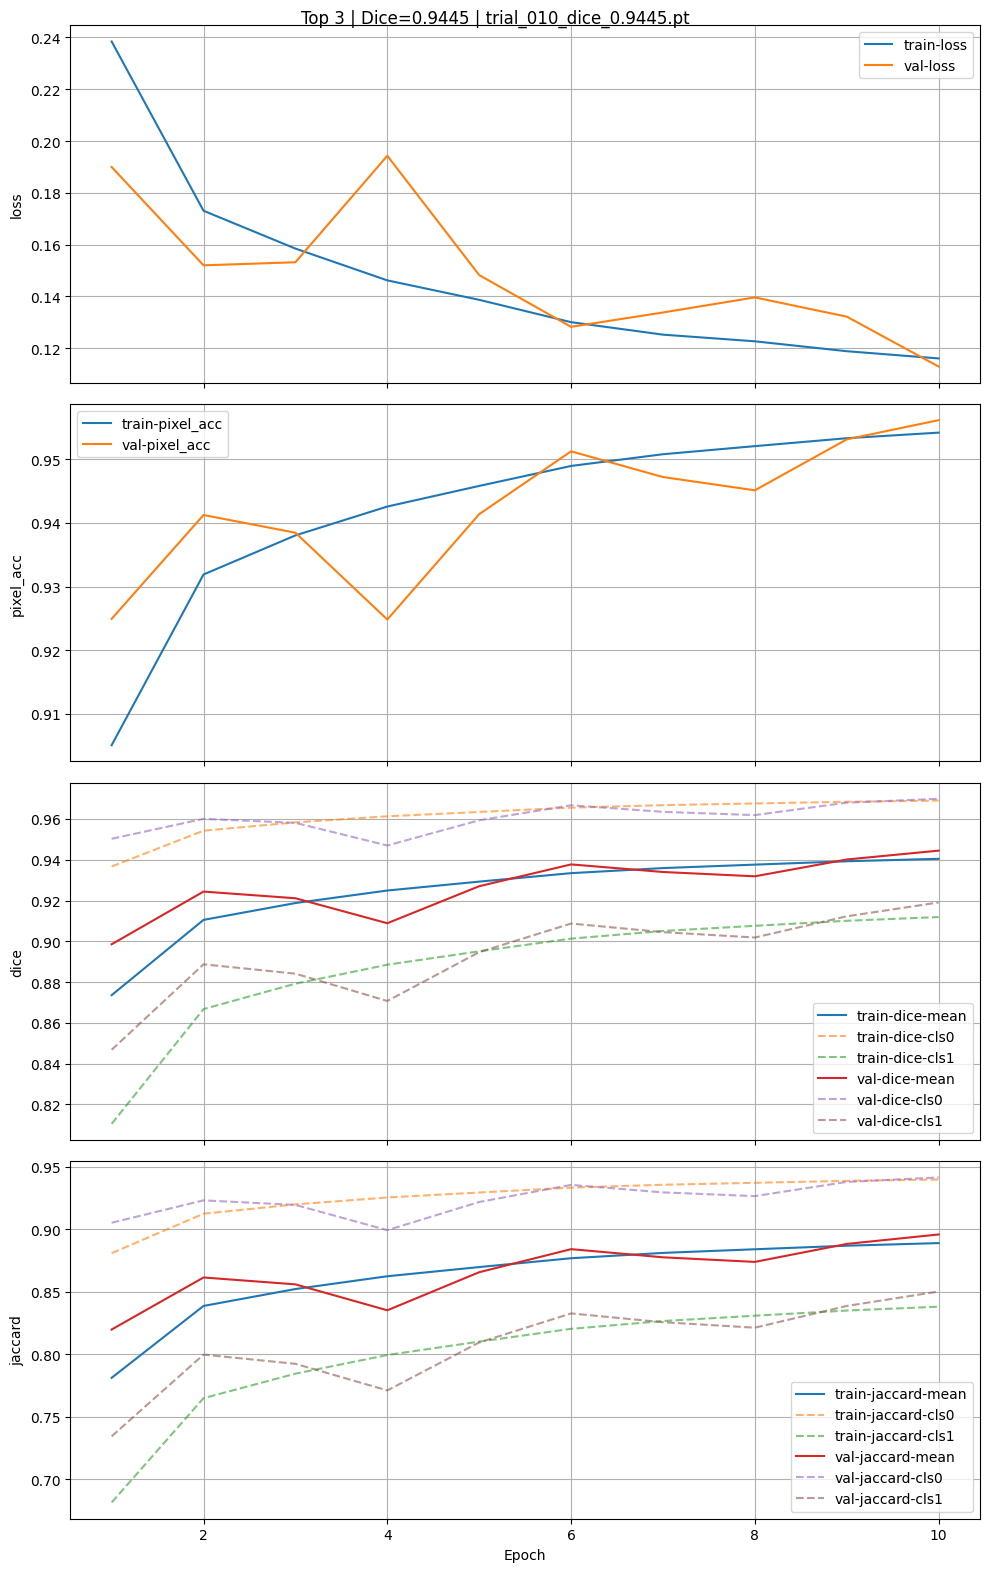

In [ ]:
def _extract_metric(history, split, metric, cls=None):
    values = []
    for record in history:
        entry = record[split]
        if metric == 'loss':
            values.append(entry['loss'])
        elif metric == 'pixel_acc':
            values.append(entry['pixel_acc'])
        elif metric in {'dice', 'jaccard'}:
            if cls is None:
                values.append(entry[metric]['mean'])
            else:
                values.append(entry[metric]['per_class'].get(cls, float('nan')))
        else:
            raise ValueError(f'Métrica desconocida: {metric}')
    return values

def plot_top_models(summary, metrics=('loss', 'pixel_acc', 'dice', 'jaccard'), splits=('train', 'val')):
    if not summary or 'top_models' not in summary:
        raise ValueError('Debes proporcionar el resumen retornado por run_trials')
    top_models = summary['top_models']
    if not top_models:
        raise ValueError('No hay modelos en el ranking top-k')
    for rank, entry in enumerate(top_models, start=1):
        payload = torch.load(entry['path'])
        history = payload['history']
        epochs = [rec['epoch'] for rec in history]
        fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4 * len(metrics)), sharex=True)
        if len(metrics) == 1:
            axes = [axes]
        fig.suptitle(f"Top {rank} | Dice={entry['score']:.4f} | {entry['path'].name}")
        for ax, metric in zip(axes, metrics):
            for split in splits:
                if metric in {'dice', 'jaccard'}:
                    mean_values = _extract_metric(history, split, metric)
                    ax.plot(epochs, mean_values, label=f"{split}-{metric}-mean")
                    for cls in range(NUM_CLASSES):
                        cls_values = _extract_metric(history, split, metric, cls=cls)
                        ax.plot(epochs, cls_values, linestyle='--', alpha=0.6, label=f"{split}-{metric}-cls{cls}")
                else:
                    values = _extract_metric(history, split, metric)
                    ax.plot(epochs, values, label=f"{split}-{metric}")
            ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend(loc='best')
        axes[-1].set_xlabel('Epoch')
        plt.tight_layout()
        plt.show()

summary = run_trials(random_trials, num_epochs=10, loss_type='cross_entropy', weights_path=WEIGHTS_PATH, top_k=3)
plot_top_models(summary)


####  Evaluación en test

Ya con los 3 modelos entrenados, se extraen de /experiments y calcula las métricas sobre el conjunto de test y se muestran algunas muestras de este conjunto con la máscara real y la que el modelo predice.

In [ ]:
def find_top_k_checkpoints(exp_dir=Path('experiments'), top_k=3):
    exp_dir = Path(exp_dir)
    if not exp_dir.exists():
        raise FileNotFoundError(f'No existe el directorio {exp_dir}')
    scored_paths = []
    for ckpt_path in exp_dir.glob('trial_*_dice_*.pt'):
        payload = torch.load(ckpt_path, map_location='cpu')
        score = payload.get('best_val_dice', float('-inf'))
        scored_paths.append((ckpt_path, score))
    if not scored_paths:
        raise RuntimeError('No se hallaron checkpoints en experiments')
    scored_paths.sort(key=lambda item: item[1], reverse=True)
    return scored_paths[:top_k]

def evaluate_top_models(exp_dir=Path('experiments'), loss_type='cross_entropy', num_examples=3, top_k=3):
    top_ckpts = find_top_k_checkpoints(exp_dir, top_k=top_k)
    results = []
    for rank, (ckpt_path, score) in enumerate(top_ckpts, start=1):
        device = get_device()
        output_channels = NUM_CLASSES if loss_type != 'bce' else 1
        model = ResUNet(n_channels=3, n_classes=output_channels).to(device)
        payload = torch.load(ckpt_path, map_location=device)
        state_dict = payload.get('state_dict', payload)
        model.load_state_dict(state_dict)
        model.eval()
        print(f"\n=== Modelo rank {rank} ===")
        print(f"Checkpoint: {ckpt_path} | Dice val={score:.4f}")
        criterion = nn.BCEWithLogitsLoss() if loss_type == 'bce' else nn.CrossEntropyLoss()
        accumulator = MetricAccumulator(num_classes=NUM_CLASSES)
        total_loss = 0.0
        total_samples = 0
        examples = []
        with torch.no_grad():
            for images, masks in test_loader:
                images = images.to(device)
                targets = prepare_targets(masks.to(device))
                logits = model(images)
                if loss_type == 'bce':
                    if logits.ndim == 3:
                        logits = logits.unsqueeze(1)
                    target_float = targets.unsqueeze(1).float()
                    loss = criterion(logits, target_float)
                else:
                    loss = criterion(logits, targets.long())
                batch = images.size(0)
                total_samples += batch
                total_loss += loss.item() * batch
                accumulator.update(logits, targets)
                if len(examples) < num_examples:
                    preds = torch.argmax(_ensure_multiclass_logits(logits), dim=1).cpu()
                    imgs_cpu = images.cpu()
                    masks_cpu = targets.cpu()
                    for idx in range(batch):
                        examples.append((imgs_cpu[idx], masks_cpu[idx], preds[idx]))
                        if len(examples) >= num_examples:
                            break
        metrics = accumulator.export()
        metrics['loss'] = total_loss / max(1, total_samples)
        print(summarize_metrics('test', metrics))
        if examples:
            mean = IMG_MEAN.view(3, 1, 1)
            std = IMG_STD.view(3, 1, 1)
            fig, axes = plt.subplots(len(examples), 3, figsize=(10, 3 * len(examples)))
            if len(examples) == 1:
                axes = np.expand_dims(axes, axis=0)
            for row, (img_t, mask_t, pred_t) in enumerate(examples):
                img_vis = torch.clamp(img_t * std + mean, 0.0, 1.0).permute(1, 2, 0).numpy()
                axes[row, 0].imshow(img_vis)
                axes[row, 0].set_title('Imagen (test)')
                axes[row, 0].axis('off')
                axes[row, 1].imshow(mask_t.numpy(), vmin=0, vmax=NUM_CLASSES - 1, cmap='viridis')
                axes[row, 1].set_title('Máscara GT')
                axes[row, 1].axis('off')
                axes[row, 2].imshow(pred_t.numpy(), vmin=0, vmax=NUM_CLASSES - 1, cmap='viridis')
                axes[row, 2].set_title('Predicción')
                axes[row, 2].axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print('No se recolectaron ejemplos de test.')
        results.append({'rank': rank, 'checkpoint': ckpt_path, 'val_dice': score, 'metrics': metrics})
    return results

# Ejemplo de uso:
top_results = evaluate_top_models(exp_dir=Path('experiments'), loss_type='cross_entropy', num_examples=3, top_k=3)
